# Gabor wavelet ridge regression

In [51]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.io as sio
import scipy.stats as stats
from sklearn.linear_model import Ridge

In [21]:
gabor = sio.loadmat('/home/elijahc/dev/sparse_Gabors_for_Will/01_gabor_activations.mat')['Y']
gabor = np.swapaxes(gabor,0,1)
gabor.shape

(270, 1089)

In [12]:
filearray = [
        '01mean50ms_smallim_d2_crop.mat',
#         '02mean50ms_smallim_d2_crop.mat', # Not using dataset 02
        '03mean50ms_smallim_d2_crop.mat',
        '04mean50ms_smallim_d2_crop.mat',
        '05mean50ms_smallim_d2_crop.mat',
        '06mean50ms_smallim_d2_crop.mat',
        '07mean50ms_smallim_d2_crop.mat',
        '08mean50ms_smallim_d2_crop.mat',
        '09mean50ms_smallim_d2_crop.mat',
        '10mean50ms_smallim_d2_crop.mat']

In [90]:
def get_partition(total, test_frac=0.2, return_bool_mask=False):
    num_total = total
    num_samples = int(test_frac*num_total)
    sample_frac = np.random.choice(num_total,num_samples,replace=False)
    bool_frac = np.bincount(sample_frac,minlength=num_total).astype(np.bool)
    if return_bool_mask:
        return (~bool_frac,bool_frac)
    else:
        return (np.arange(num_total)[bool_frac],np.arange(num_total)[~bool_frac])
    
def ridge_regression(x,y,validation_frac=1.0/7,alpha=1.0):
    num_samples = x.shape[0]
    num_cells = y.shape[1]
    
    train_idx,test_idx = get_partition(num_samples,validation_frac,True)
    
    x_train,x_test = x[train_idx], x[test_idx]
    y_train,y_test = y[train_idx], y[test_idx]
    num_test = y_test.shape[0]
    
    clf = Ridge(alpha=alpha)
    clf.fit(x_train,y_train)
    
    y_pred = clf.predict(x_test)
    
    r_eval = [stats.pearsonr(y_pred[:,i],y_test[:,i])[0] for i in np.arange(num_cells)]
    
    return np.array(r_eval)

In [78]:
v1_data_path = '/home/elijahc/dev/v1_predictor/data/'
files = [sio.loadmat(os.path.join(v1_data_path,fn))['activity'] for fn in filearray]
files[2].shape

(270, 28)

In [79]:
r_eval.shape

(76, 7)

In [91]:
recs = []

for act_dat,filename in zip(files,filearray):
    num_trials = 7
    r_eval = np.concatenate([ridge_regression(x=gabor,y=act_dat,alpha=1000).reshape(-1,1) for _ in np.arange(num_trials)],axis=1)
    num_cells = r_eval.shape[0]
    for i in np.arange(num_trials):
        for j in np.arange(num_cells):
            recs.append(dict(
                trial=i,
                neuron=j,
                r_eval=r_eval[j,i],
                dataset=filename[:2]
            ))
        
gabor_df = pd.DataFrame.from_records(recs)

In [92]:
gabor_df.head()

,dataset,neuron,r_eval,trial
0,01,0,0.505895,0
1,01,1,0.341793,0
2,01,2,0.265667,0
3,01,3,0.179127,0
4,01,4,0.480633,0


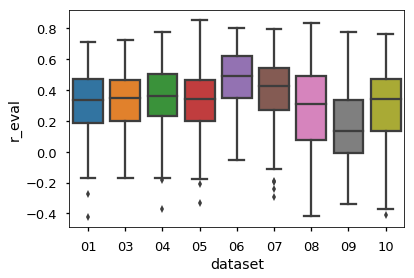

In [93]:
sns.set_context('talk')
sns.boxplot(x='dataset',y='r_eval',data=gabor_df)

In [94]:
cols = ['dataset','trial','neuron','r_eval']
data = gabor_df[cols].values

In [95]:
sio.savemat('./gabor_regression_a1000.mat',{'columns':cols,'gabor_results':data})

In [96]:
os.getcwd()

'/home/elijahc/projects/JoV resubmission'